In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import linear_model, datasets
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from datetime import datetime, date, time, timedelta
%matplotlib inline

### Reading the data after preprocessing

In [2]:
AAPL = pd.read_csv('../Data/X.csv')

C:\Users\jason\Anaconda3\envs\ipykernel_py2\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (129) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Independent variable:
* mid-price movement

In [3]:
def midprice_movement(mid, delta_t):
    mid_diff = mid.diff(periods=delta_t)[delta_t:].ravel()
    mid_diff = np.append(mid_diff, np.array(np.nan).repeat(delta_t))
    
    mid_movement = (mid_diff > 0)*1 + (mid_diff < 0)*-1
    mid_movement = mid_movement.astype('float')
    mid_movement[-delta_t:] = np.nan
    
    # Change to pandas series and transform to categorical data
    mid_movement = pd.Series(pd.Categorical(mid_movement, categories=[-1, 0, 1]))
    
    # Change label
    mid_movement.cat.categories = ['down', 'stationary', 'up']
    
    return(mid_movement)

In [4]:
# Create mid-price movement
AAPL['MID_MOVEMENT'] = midprice_movement(AAPL['MID_PRICE1'], 10)

In [5]:
AAPL['MID_MOVEMENT'].value_counts()

stationary    120488
down          109929
up            102246
dtype: int64

* bid-ask spread crossing    

For bid-ask spread crossing, we have to consider three scenarios:
1. An __upward__ price spread crossing occurs when the best bid price at $t+\Delta t$ exceeds the best ask price at time $t$ $\Rightarrow$ $P^{bid}_{t + \Delta t} > P^{ask}_{t}$ 
2. A __downward__ price spread crossing happens when the best ask price at $t+\Delta t$ is less than the best bid price at time $t$ $\Rightarrow$ $P^{ask}_{t + \Delta t} < P^{bid}_{t}$ 
3. No price spread crossing takes place if $P^{ask}_{t + \Delta t} \leq P^{bid}_{t}$ and $P^{bid}_{t + \Delta t} \geq P^{ask}_{t}$ 

In [6]:
def spread_crossing(bid, ask, delta_t):
    # shifted bid (append nan at the last)
    bid_shift = np.append(bid[delta_t:], np.array(np.nan).repeat(delta_t))
    ask_shift = np.append(ask[delta_t:], np.array(np.nan).repeat(delta_t))
    
    # Determine up or down
    spread = (bid_shift > ask)*1 + (ask_shift < bid)*-1
    spread = spread.astype('float')
    spread[-delta_t:] = np.nan
    
    # Change to pandas series and transform to categorical data
    spread = pd.Series(pd.Categorical(spread, categories=[-1, 0, 1]))

    # Change label
    spread.cat.categories = ['down', 'stationary', 'up']
    
    return(spread)

In [7]:
# Create spread crossing movement
AAPL['SPREAD_CROSSING'] = spread_crossing(AAPL['BID_PRICE1'], AAPL['ASK_PRICE1'], 1000)

In [8]:
AAPL['SPREAD_CROSSING'].value_counts()

stationary    123000
down          112585
up             96088
dtype: int64

### First (before 11:00) vs. Second (after 11:00)

In [9]:
# Create time variable
time = np.array([datetime.strptime(time, "%Y/%m/%d %H:%M:%S.%f") for time in AAPL['Time']])

# Separate time by 11:00
first_index = time < datetime(2012, 5, 22, 11, 0)

# Separate training and testing set
first = AAPL.iloc[first_index]
second = AAPL.iloc[np.logical_not(first_index)]

In [10]:
first.shape

(203349, 130)

In [11]:
second.shape

(129324, 130)

### Train, Validation and Test

In [28]:
index = np.arange(first.shape[0])

train = first.iloc[index[0:101675]]
validation = first.iloc[index[101675:152512]]
test = first.iloc[index[152512:]]

# Pull out the column name in x
r_not_x = re.compile('TIME|INDEX|MID_MOVEMENT|SPREAD_CROSSING')
col_in_x = [not bool(r_not_x.search(col.upper())) for col in AAPL.columns]

# Separate X, y1(midprice), y2(spreadcrossing)
X_train = train.iloc[:, col_in_x]
y1_train = train['MID_MOVEMENT']
y2_train = train['SPREAD_CROSSING']

X_validation = validation.iloc[:, col_in_x]
y1_validation = validation['MID_MOVEMENT']
y2_validation = validation['SPREAD_CROSSING']

X_test = test.iloc[:, col_in_x]
y1_test = test['MID_MOVEMENT']
y2_test = test['SPREAD_CROSSING']

### Mid-price Movement

### SVM

In [ ]:
# Paramemter range
C_range = 10.0**np.arange(2, 5, 1)
gamma_range = 10.0**np.arange(-7, -4, 1)

# Validation
V = []
for C in C_range:
    for gamma in gamma_range:
        print('Start to fit the model with C =', str(C), 'and gamma =', str(gamma))
        clf = svm.SVC(C=C, gamma=gamma)
        clf.fit(X_train.iloc[index[0:50000]], y1_train[index[0:50000]])
        prediction = clf.predict(X_validation)
        accuracy = np.mean(prediction == y1_validation)
        print(accuracy)
        V.append([C, gamma, accuracy])

Start to fit the model with C = 100.0 and gamma = 1e-07
0.339083738222
Start to fit the model with C = 100.0 and gamma = 1e-06
0.334775852234
Start to fit the model with C = 100.0 and gamma = 1e-05
0.331431831147
Start to fit the model with C = 1000.0 and gamma = 1e-07
0.343588331333
Start to fit the model with C = 1000.0 and gamma = 1e-06
0.329150028523
Start to fit the model with C = 1000.0 and gamma = 1e-05
0.318724551016
Start to fit the model with C = 10000.0 and gamma = 1e-07


In [14]:
def model_assessment(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)
    
    df = pd.concat([pd.Series(precision), pd.Series(recall), pd.Series(f1)], axis=1)
    df.columns = ['precision', 'recall', 'f1']
    df.index = ['down', 'stationary', 'up']
    
    return(df)

In [14]:
clf = svm.SVC(C=100, gamma=0.000001)
clf.fit(X_train.iloc[index[0:50000]], y1_train[index[0:50000]])
prediction = clf.predict(X_test)
model_assessment(y1_test, prediction)

,precision,recall,f1
down,0.326829,0.512778,0.399212
stationary,0.386208,0.164167,0.230398
up,0.302561,0.338345,0.319454


In [15]:
# Confusion Matrix
pd.crosstab(y1_test, prediction, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,down,stationary,up,All
True,,,,
down,8307,2481,5412,16200
stationary,9430,3153,6623,19206
up,7680,2530,5221,15431
All,25417,8164,17256,50837


### Random Forest

In [21]:
# Parameters
ns_tree = [50, 100, 200]
ns_features = ['sqrt', 'log2']

V = []
for n in ns_tree:
    for m in ns_features:
        print('Start to fit the model with number of tree =', str(n), 'and number of features =', str(m))
        rf_clf = RandomForestClassifier(n_estimators=n, max_features=m)
        rf_clf.fit(X_train, y1_train)
        prediction = rf_clf.predict(X_validation)
        accuracy = np.mean(prediction == y1_validation)
        print(accuracy)
        V.append([n, m, accuracy])

Start to fit the model with number of tree = 50 and number of features = sqrt
0.334795522946
Start to fit the model with number of tree = 50 and number of features = log2
0.330802368354
Start to fit the model with number of tree = 100 and number of features = sqrt
0.350551763479
Start to fit the model with number of tree = 100 and number of features = log2
0.328894309263
Start to fit the model with number of tree = 200 and number of features = sqrt
0.341778625804
Start to fit the model with number of tree = 200 and number of features = log2
0.33068434408


In [15]:
rf_clf = RandomForestClassifier(n_estimators=100, max_features='sqrt')
rf_clf.fit(X_train.append(X_validation), y1_train.append(y1_validation))

prediction = rf_clf.predict(X_test)
model_assessment(y1_test, prediction)

,precision,recall,f1
down,0.379712,0.619259,0.470765
stationary,0.473574,0.164220,0.243872
up,0.401419,0.461927,0.429553


In [16]:
# Confusion Matrix
pd.crosstab(y1_test, prediction, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,down,stationary,up,All
True,,,,
down,10032,1721,4447,16200
stationary,9870,3154,6182,19206
up,6518,1785,7128,15431
All,26420,6660,17757,50837


### Spread Crossing

### SVM

In [14]:
C_range = 10.0**np.arange(2, 5, 1)
gamma_range = 10.0**np.arange(-7, -4, 1)

# Validation
V = []
for C in C_range:
    for gamma in gamma_range:
        print('Start to fit the model with C =', str(C), 'and gamma =', str(gamma))
        clf = svm.SVC(C=C, gamma=gamma)
        clf.fit(X_train.iloc[0:50000], y2_train[0:50000])
        prediction = clf.predict(X_validation)
        accuracy = np.mean(prediction == y2_validation)
        print(accuracy)
        V.append([C, gamma, accuracy, clf])

Start to fit the model with C = 100.0 and gamma = 1e-07
0.320258866574
Start to fit the model with C = 100.0 and gamma = 1e-06
0.328599248579
Start to fit the model with C = 100.0 and gamma = 1e-05
0.359954363948
Start to fit the model with C = 1000.0 and gamma = 1e-07
0.331884257529
Start to fit the model with C = 1000.0 and gamma = 1e-06
0.329071345673
Start to fit the model with C = 1000.0 and gamma = 1e-05
0.359128194032
Start to fit the model with C = 10000.0 and gamma = 1e-07
0.333870999469
Start to fit the model with C = 10000.0 and gamma = 1e-06
0.325471605327
Start to fit the model with C = 10000.0 and gamma = 1e-05
0.358439719102


In [15]:
clf = svm.SVC(C=10000, gamma=0.00001)
clf.fit(X_train[0:50000], y2_train[0:50000])
prediction = clf.predict(X_test)
model_assessment(y2_test, prediction)

,precision,recall,f1
down,0.348737,0.710360,0.467811
stationary,0.386863,0.131097,0.195832
up,0.333462,0.202215,0.251760


In [16]:
# Confusion Matrix
pd.crosstab(y2_test, prediction, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,down,stationary,up,All
True,,,,
down,12150,1600,3354,17104
stationary,10938,2185,3544,16667
up,11752,1863,3451,17066
All,34840,5648,10349,50837


### Random Forest

In [25]:
# Divide train, validation, and test by time
# Takes about 50 mins
# Parameters
ns_tree = [50, 100, 200]
ns_features = ['sqrt', 'log2']

V = []
for n in ns_tree:
    for m in ns_features:
        print('Start to fit the model with number of tree =', str(n), 'and number of features =', str(m))
        rf_clf = RandomForestClassifier(n_estimators=n, max_features=m)
        rf_clf.fit(X_train, y2_train)
        prediction = rf_clf.predict(X_validation)
        accuracy = np.mean(prediction == y2_validation)
        print(accuracy)
        V.append([n, m, accuracy])

Start to fit the model with number of tree = 50 and number of features = sqrt
0.244034856502
Start to fit the model with number of tree = 50 and number of features = log2
0.245608513484
Start to fit the model with number of tree = 100 and number of features = sqrt
0.246395341975
Start to fit the model with number of tree = 100 and number of features = log2
0.242303833822
Start to fit the model with number of tree = 200 and number of features = sqrt
0.243661112969
Start to fit the model with number of tree = 200 and number of features = log2
0.24271691878


In [28]:
rf_clf = RandomForestClassifier(n_estimators=100, max_features='sqrt')
rf_clf.fit(X_train.append(X_validation), y2_train.append(y2_validation))
prediction = rf_clf.predict(X_test)
model_assessment(y2_test, prediction)

,precision,recall,f1
down,0.337117,0.520872,0.409317
stationary,0.317889,0.221876,0.261343
up,0.380919,0.285187,0.326174


In [29]:
# Confusion Matrix
pd.crosstab(y2_test, prediction, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,down,stationary,up,All
True,,,,
down,8909,4536,3659,17104
stationary,8718,3698,4251,16667
up,8800,3399,4867,17066
All,26427,11633,12777,50837


### Feature Selection

Feature ranking:
1. feature 82 (0.014982)
2. feature 83 (0.014863)
3. feature 36 (0.014860)
4. feature 85 (0.014442)
5. feature 32 (0.014414)
6. feature 61 (0.013758)
7. feature 0 (0.013736)
8. feature 2 (0.013478)
9. feature 60 (0.013228)
10. feature 20 (0.012762)


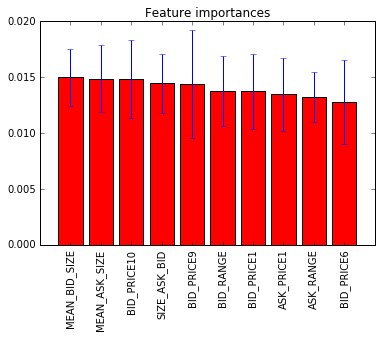

In [35]:
forest = ExtraTreesClassifier(n_estimators=100, max_features='log2',
                              random_state=0)
forest.fit(X_train.append(X_validation), y2_train.append(y2_validation))
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1])[:10], importances[indices[:10]],
       color="r", yerr=std[indices[:10]], align="center")
plt.xticks(range(X_train.shape[1])[:10], X_train.columns[indices[:10]], rotation=90)
plt.xlim([-1, 10])
plt.show()

In [33]:
X_train.columns[[82, 83, 36, 85, 32, 61, 0, 2, 60, 20]]

Index([u'MEAN_BID_SIZE', u'MEAN_ASK_SIZE', u'BID_PRICE10', u'SIZE_ASK_BID',
       u'BID_PRICE9', u'BID_RANGE', u'BID_PRICE1', u'ASK_PRICE1', u'ASK_RANGE',
       u'BID_PRICE6'],
      dtype='object')

### Logistic Regression for Spread Crossing

In [29]:
# Create new variable: ratio of bid size and ask size
ratio = (X_train.ASK_SIZE1 + X_train.ASK_SIZE2 + X_train.ASK_SIZE3 + X_train.ASK_SIZE4 + X_train.ASK_SIZE5)*1.0/(X_train.BID_SIZE1 + X_train.BID_SIZE2 + X_train.BID_SIZE3 + X_train.BID_SIZE4 + X_train.BID_SIZE5)

X_train['ratio'] = ratio

# Validation
ratio_val = (X_validation.ASK_SIZE1 + X_validation.ASK_SIZE2 + X_validation.ASK_SIZE3 + X_validation.ASK_SIZE4 + X_validation.ASK_SIZE5)*1.0/(X_validation.BID_SIZE1 + X_validation.BID_SIZE2 + X_validation.BID_SIZE3 + X_validation.BID_SIZE4 + X_validation.BID_SIZE5)
X_validation['ratio'] = ratio_val

# Test
ratio_test = (X_test.ASK_SIZE1 + X_test.ASK_SIZE2 + X_test.ASK_SIZE3 + X_test.ASK_SIZE4 + X_test.ASK_SIZE5)*1.0/(X_test.BID_SIZE1 + X_test.BID_SIZE2 + X_test.BID_SIZE3 + X_test.BID_SIZE4 + X_test.BID_SIZE5)
X_test['ratio'] = ratio_test

C:\Users\jason\Anaconda3\envs\ipykernel_py2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\jason\Anaconda3\envs\ipykernel_py2\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\jason\Anaconda3\envs\ipykernel_py2\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pa

In [24]:
logreg.fit(X_train[:10000], y2_train[:10000])

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [30]:
c_set = [100,1e3,1e4,1e5,1e6,1e7,1e8]
for c in c_set:
    logreg = linear_model.LogisticRegression(C=c)

    logreg.fit(X_train[:5000], y2_train[:5000]) 
    y2_pre_log = logreg.predict(X_validation)
    accuracy = np.sum(y2_pre_log == y2_validation)/50837.0
    
    print(c, accuracy)

100 0.360249424632
1000.0 0.362000118024
10000.0 0.360052717509
100000.0 0.362845958652
1000000.0 0.361055923835
10000000.0 0.360859216712
100000000.0 0.364852371304


In [31]:
logreg.fit(X_train[:10000], y2_train[:10000])

LogisticRegression(C=100000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [37]:
y2_prediction_test = logreg.predict(X_test)

In [36]:
logreg.coef_[:, 126]

array([-0.04948695,  0.20226608, -0.08213178])

In [38]:
ind = np.abs(logreg.coef_[0,:]).argsort()[-3:]
logreg.coef_[0,:][ind],X_train.columns[ind]

(array([ 0.39389342, -0.45961729,  0.59549729]),
 Index([u'BID_RANGE', u'SPREAD5', u'SPREAD10'], dtype='object'))

In [39]:
ind = np.abs(logreg.coef_[1,:]).argsort()[-3:]
logreg.coef_[1,:][ind],X_train.columns[ind]

(array([-0.25713995, -0.36788657,  0.40280117]),
 Index([u'BID_PRICE1', u'BID_RANGE', u'PRICE_ASK_BID'], dtype='object'))

In [40]:
ind = np.abs(logreg.coef_[2,:]).argsort()[-3:]
logreg.coef_[2,:][ind],X_train.columns[ind]

(array([-0.72021271,  0.72635669, -1.04013647]),
 Index([u'ASK_RANGE', u'SPREAD5', u'SPREAD10'], dtype='object'))

In [41]:
model_assessment(y2_prediction_test, y2_test)

,precision,recall,f1
down,0.071738,0.368579,0.120100
stationary,0.002100,0.241379,0.004164
up,0.937888,0.337943,0.496857


### Strategy and Profit

### SVM

In [13]:
clf = svm.SVC(C=100, gamma=1e-6)
clf.fit(X_train[:30000], y2_train[:30000])

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=1e-06, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Random Forest

In [14]:
# Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, max_features='sqrt')
rf_clf.fit(X_train, y2_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Compute Profit

In [42]:
def compute_profit(data, classifier, delta_t, predictions, provide=False):
    # The price we buy the share or short sell the share
    profit = np.zeros(len(data)/delta_t)
    i, j = 0, 0
    
    while i < len(data) - delta_t:
        # If user directly provide the prediction, just use the predicted value
        if provide:
            prediction = predictions.iloc[i]
        else:
            prediction = classifier.predict(data.iloc[i].reshape(1, -1))
         
        # Determine the trading of each observation 
        if prediction == 'stationary': 
            #print('The movement of', str(i), 'observation is stationary')
            i = i + 1
        elif prediction == 'up':
            #print('The movement of', str(i), 'observation is up')
            p_ask = data['ASK_PRICE1'].iloc[i]
            i = i + delta_t
            p_bid = data['BID_PRICE1'].iloc[i]
            #print('The profit of this trading is', str(profit[j]))
            #print('Current profit is', str(sum(profit)))
            profit[j] = p_bid - p_ask
            i += 1
            j += 1
        elif prediction == 'down':
            #print('The movement of', str(i), 'observation is down')
            p_bid = data['BID_PRICE1'].iloc[i]
            i = i + delta_t
            p_ask = data['ASK_PRICE1'].iloc[i]
            profit[j] = p_bid - p_ask
            #print('The profit of this trading is', str(profit[j]))
            #print('Current profit is', str(sum(profit)))
            i += 1
            j += 1
            
    return(profit)

In [114]:
# SVM
profit = compute_profit(second.iloc[:, col_in_x], clf, 1000, 0)
profit

array([ 0.3 , -0.62, -0.32, -0.28, -0.15, -0.87, -0.15, -0.19, -0.25,
       -0.34, -0.28,  0.48, -0.48, -0.03, -0.79, -0.58, -0.12, -0.26,
       -0.18, -0.22, -0.01, -0.08, -0.03, -0.33,  0.77, -0.11,  0.58,
        0.06, -0.36, -0.65, -0.27, -0.27, -0.4 , -0.52, -0.15,  0.18,
       -0.1 , -0.05,  0.01, -0.14, -0.9 ,  0.25, -0.08, -0.41, -0.4 ,
        0.37, -0.02, -0.28, -0.3 , -0.3 , -0.07, -0.19,  0.28,  0.18,
       -0.58, -0.44, -0.2 ,  0.28, -0.01,  0.17, -0.02,  0.29,  0.28,
        0.21, -0.28,  0.36, -0.23,  0.07,  0.41, -0.71,  0.55,  0.26,
       -0.41, -0.45, -0.18, -0.23, -0.2 ,  0.02,  0.23, -0.86, -0.08,
        0.23, -1.05,  0.42,  0.55,  0.14, -0.04,  0.46, -0.03, -0.67,
       -0.09, -0.85, -0.01, -0.01,  0.29, -0.05, -0.02,  0.1 ,  0.29,
       -0.26, -0.41, -0.14, -0.75, -0.29, -1.15, -0.46, -0.25, -0.2 ,
        0.35, -0.49, -0.4 , -0.33, -0.88, -0.67, -0.09,  0.54, -0.39,
       -0.64,  0.1 , -0.47,  0.2 , -0.74,  0.43, -0.49, -0.05, -0.51,
       -0.27, -0.93,

In [115]:
sum(profit)

-20.799999999999613

In [116]:
# random forest
profit = compute_profit(second.iloc[:, col_in_x], rf_clf, 1000, False)
profit

array([ 0.3 ,  0.35, -0.19, -0.25, -0.32, -0.87, -0.28, -0.25, -0.07,
        0.03, -0.28, -0.66,  0.  , -0.29,  0.22,  0.18, -0.43, -0.1 ,
       -0.14, -0.09, -0.38, -0.01, -0.33, -0.14,  0.62,  0.05,  0.42,
        0.2 , -0.19, -0.74, -0.3 ,  0.32, -0.76, -0.24, -0.49, -0.67,
       -0.31,  0.07, -0.43, -0.12,  0.57, -0.83, -0.28, -0.09,  0.16,
       -0.65, -0.16, -0.34, -0.09, -0.48, -0.12, -0.02, -0.79, -0.28,
        0.28, -0.65, -0.2 , -0.75, -0.1 , -0.66, -0.13,  0.3 ,  0.21,
        0.08, -0.39, -0.39, -0.43,  0.41, -0.98, -0.9 , -0.82, -0.43,
       -0.49, -0.49,  0.05, -0.36, -0.33, -0.59, -0.53,  0.3 ,  0.18,
       -0.02, -0.68,  0.19, -0.81, -0.49, -0.29, -0.96, -0.22,  0.1 ,
        0.34, -0.6 , -0.99,  0.05, -0.44, -0.45,  0.  , -0.11,  0.45,
       -0.54,  0.25, -0.21, -0.32, -0.43,  0.42,  0.28,  0.31, -0.43,
       -0.44, -0.63,  0.19, -0.67,  0.56,  0.06,  0.47,  0.28,  0.48,
        0.02, -0.12, -0.26,  0.07, -0.01, -0.38, -0.59, -0.34,  0.1 ,
       -0.46, -0.03,

In [117]:
sum(profit)

-24.540000000000532

In [44]:
# Create ratio
ratio = (second.ASK_SIZE1 + second.ASK_SIZE2 + second.ASK_SIZE3 + second.ASK_SIZE4 + second.ASK_SIZE5)*1.0/(second.BID_SIZE1 + second.BID_SIZE2 + second.BID_SIZE3 + second.BID_SIZE4 + second.BID_SIZE5)
second['ratio'] = ratio

C:\Users\jason\Anaconda3\envs\ipykernel_py2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [46]:
# Pull out the column name in x
r_not_x = re.compile('TIME|INDEX|MID_MOVEMENT|SPREAD_CROSSING')
col_in_x = [not bool(r_not_x.search(col.upper())) for col in second.columns]

In [47]:
# Logistic Regression
profit = compute_profit(second.iloc[:, col_in_x], logreg, 1000, 0)
profit

array([ 0.3 ,  0.35, -0.19, -0.25, -0.32, -0.87, -0.28, -0.25, -0.07,
        0.03, -0.28, -0.66,  0.  , -0.29,  0.22,  0.18, -0.43, -0.1 ,
       -0.14, -0.09, -0.38, -0.01, -0.33, -0.23,  0.62,  0.05,  0.42,
        0.2 , -0.19, -0.74, -0.3 ,  0.32, -0.76, -0.24, -0.49, -0.67,
       -0.31,  0.07, -0.43, -0.12,  0.57, -0.83, -0.28, -0.09, -0.61,
       -0.65, -0.16, -0.34, -0.09, -0.48, -0.4 , -0.02, -0.79, -0.28,
        0.28, -0.65, -0.2 , -0.75, -0.1 , -0.66, -0.13,  0.3 ,  0.21,
        0.08, -0.39, -0.39, -0.43,  0.41, -0.98, -0.9 , -0.82,  0.11,
       -0.49, -0.49, -0.36, -0.36, -0.33, -0.59, -0.53,  0.3 ,  0.18,
       -0.02, -0.68, -0.5 , -0.81, -0.49, -0.29, -0.96,  0.  ,  0.1 ,
        0.34, -0.6 , -0.99,  0.05, -0.44, -0.45, -0.35, -0.11,  0.45,
       -0.54,  0.25, -0.21, -0.32, -0.43,  0.42,  0.28,  0.31, -0.43,
       -0.44, -0.63,  0.19, -0.67,  0.56,  0.06,  0.47,  0.28,  0.48,
        0.02, -0.12, -0.26,  0.07, -0.01, -0.38, -0.59, -0.34, -0.3 ,
       -0.46, -0.03,

In [48]:
sum(profit)

-26.770000000000664

In [49]:
# All correct
profit = compute_profit(second.iloc[:, col_in_x], rf_clf, 1000, second['SPREAD_CROSSING'], True)
profit

array([ 0.3 ,  0.35,  0.01,  0.05,  0.1 ,  0.16,  0.07,  0.2 ,  0.02,
        0.37,  0.05,  0.09,  0.38,  0.03,  0.02,  0.15,  0.05,  0.18,
        0.16,  0.01,  0.01,  0.35,  0.22,  0.21,  0.55,  0.03,  0.3 ,
        0.07,  0.25,  0.34,  0.05,  0.04,  0.23,  0.03,  0.03,  0.05,
        0.5 ,  0.02,  0.08,  0.01,  0.26,  0.51,  0.06,  0.01,  0.01,
        0.04,  0.01,  0.09,  0.47,  0.03,  0.01,  0.05,  0.36,  0.01,
        0.02,  0.11,  0.28,  0.1 ,  0.03,  0.09,  0.05,  0.31,  0.48,
        0.46,  0.37,  0.31,  0.1 ,  0.34,  0.09,  0.01,  0.01,  0.12,
        0.01,  0.28,  0.02,  0.06,  0.01,  0.16,  0.24,  0.34,  0.07,
        0.07,  0.28,  0.01,  0.04,  0.68,  0.1 ,  0.18,  0.12,  0.07,
        0.22,  0.37,  0.01,  0.24,  0.11,  0.35,  0.06,  0.48,  0.18,
        0.05,  0.05,  0.32,  0.5 ,  0.1 ,  0.42,  0.04,  0.37,  0.21,
        0.58,  0.07,  0.17,  0.06,  0.07,  0.01,  0.14,  0.39,  0.03,
        0.16,  0.09,  0.08,  0.62,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,

In [50]:
sum(profit)

20.610000000000014

* [sklearn: SVM](http://scikit-learn.org/stable/modules/svm.html)
* [sklearn: Ensemble methods](http://scikit-learn.org/stable/modules/ensemble.html)
* [sklearn: Random Forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* [sklearn: Feature importances with forests of trees](http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)